In [3]:
# Cell 1: Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import datetime


In [12]:
import yfinance as yf
# Cell 2: Data Collection - Download historical stock data (e.g., GE)
# Define the stock symbol and the period of data
symbol = 'GE'
start_date = '2018-01-01'
end_date = '2025-02-05'

# Download historical data using yfinance
df = yf.download(symbol, start=start_date, end=end_date)

# Save the data to a CSV file for further processing
df.to_csv("GE_Aerospace_Data.csv")

# Use the 'Close' price for prediction
df = df[['Close']]
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,GE
Date,
2018-01-02,81.634674
2018-01-03,82.406517
2018-01-04,84.131859
2018-01-05,84.177246
2018-01-08,82.996788


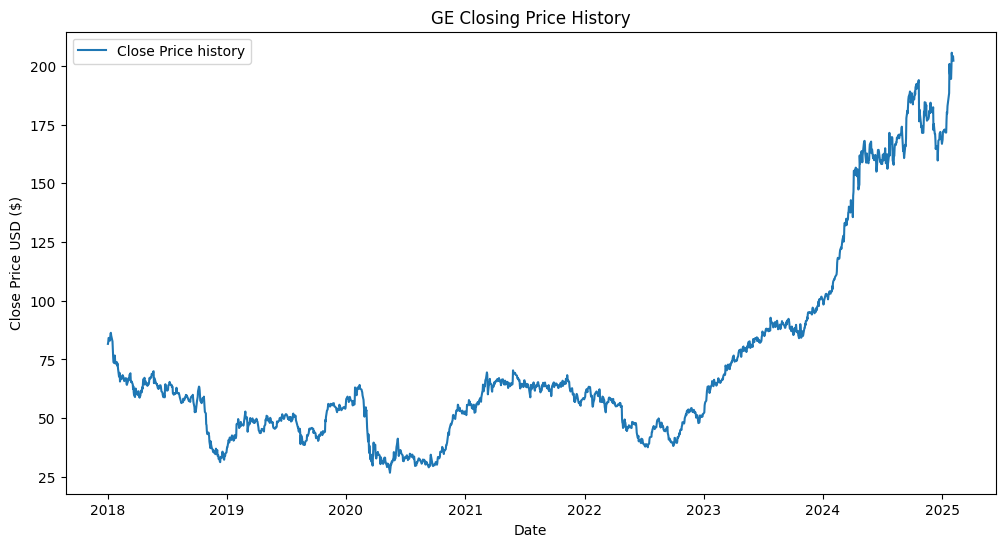

Training samples: 1425
Testing samples: 357


In [13]:
# Cell 3: Data Preprocessing

# Plot the closing price history
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price history')
plt.title(f'{symbol} Closing Price History')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()

# Create a new column for our prediction target: the next day's close
df['Prediction'] = df['Close'].shift(-1)

# Remove the last row (with NaN prediction)
df.dropna(inplace=True)

# Create features and labels for Linear Regression
X = np.array(df['Close']).reshape(-1, 1)
y = np.array(df['Prediction']).reshape(-1, 1)

# Split data into training and testing sets (80% train, 20% test)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Training samples:", len(X_train_lr))
print("Testing samples:", len(X_test_lr))


Linear Regression MSE: 8.4708
Linear Regression R2 Score: 0.9936


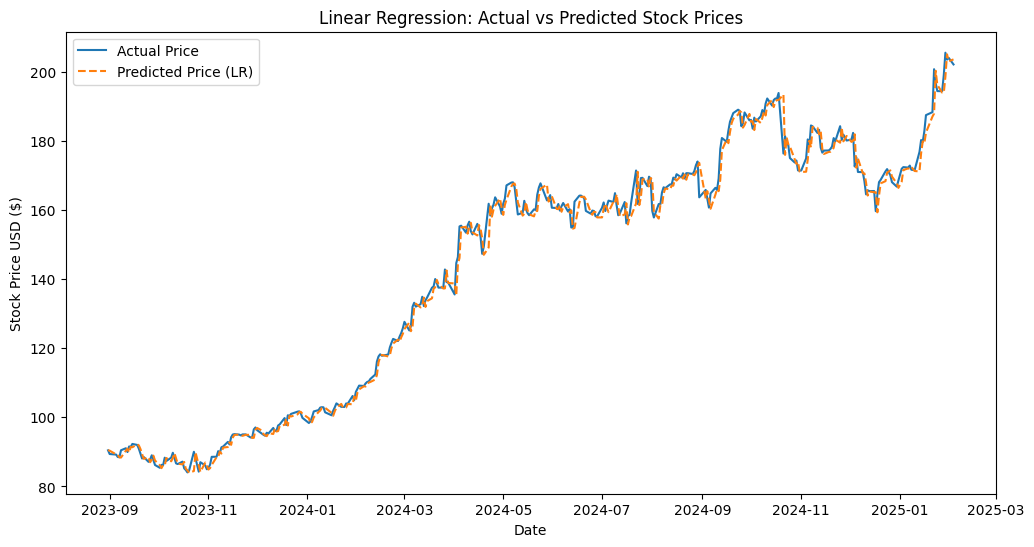

In [14]:
# Cell 4: Linear Regression Model

# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test_lr)

# Evaluate the model
mse_lr = mean_squared_error(y_test_lr, y_pred_lr)
r2_lr = r2_score(y_test_lr, y_pred_lr)
print(f'Linear Regression MSE: {mse_lr:.4f}')
print(f'Linear Regression R2 Score: {r2_lr:.4f}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test_lr):], y_test_lr, label='Actual Price')
plt.plot(df.index[-len(y_test_lr):], y_pred_lr, label='Predicted Price (LR)', linestyle='--')
plt.title('Linear Regression: Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price USD ($)')
plt.legend()
plt.show()


In [16]:
# Cell 5: Data Preprocessing for LSTM

# For LSTM we need to scale the data and create a time-series dataset
# Ensure 'Close' column exists, if not, try using the original 'Close' column from df
# If the 'Close' column was renamed or removed in previous steps,
# you need to adjust the column name here accordingly.
# Assuming 'Close' still exists:
data = df[['Close']]
dataset = data.values

# Scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Define the prediction time frame (e.g., use 60 days to predict next day)
prediction_days = 60

# Create the training data for LSTM
x_train, y_train = [], []
for i in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[i-prediction_days:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data into 3D shape (samples, time_steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print("LSTM Training data shape:", x_train.shape)

LSTM Training data shape: (1722, 60, 1)


In [17]:
# Cell 6: Build and Train the LSTM Model

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

# Train the LSTM model
epochs = 50  # adjust as needed
batch_size = 32
history = lstm_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0288
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.7868e-04
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4335e-04
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8088e-04
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.0714e-04
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4088e-04
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.8938e-04
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.3867e-04
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2608e-04
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.5579e-04
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2150e-04
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2242e-04
Epoch 13/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3876e-04
Epoch 14/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3787e-04
Epoch 15/50
54/54 ━━━━━━━━━━━

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
LSTM Model MSE: 9.3389


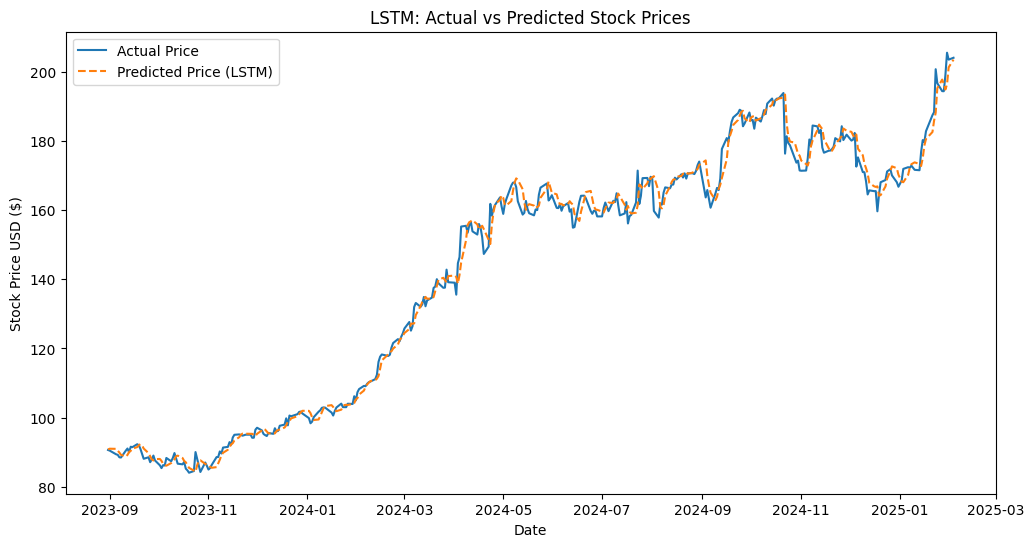

In [18]:
# Cell 7: Testing the LSTM Model

# Create the testing dataset
# The test set is the last portion of the scaled data
test_data = scaled_data[-(prediction_days + len(X_test_lr)):]
x_test_lstm = []
y_test_lstm = dataset[-(len(X_test_lr)):]  # actual prices

for i in range(prediction_days, len(test_data)):
    x_test_lstm.append(test_data[i-prediction_days:i, 0])

x_test_lstm = np.array(x_test_lstm)
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1], 1))

# Make predictions with LSTM
lstm_predictions = lstm_model.predict(x_test_lstm)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Evaluate LSTM model
mse_lstm = mean_squared_error(y_test_lstm, lstm_predictions)
print(f'LSTM Model MSE: {mse_lstm:.4f}')

# Plot the results for LSTM
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test_lstm):], y_test_lstm, label='Actual Price')
plt.plot(df.index[-len(y_test_lstm):], lstm_predictions, label='Predicted Price (LSTM)', linestyle='--')
plt.title('LSTM: Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price USD ($)')
plt.legend()
plt.show()


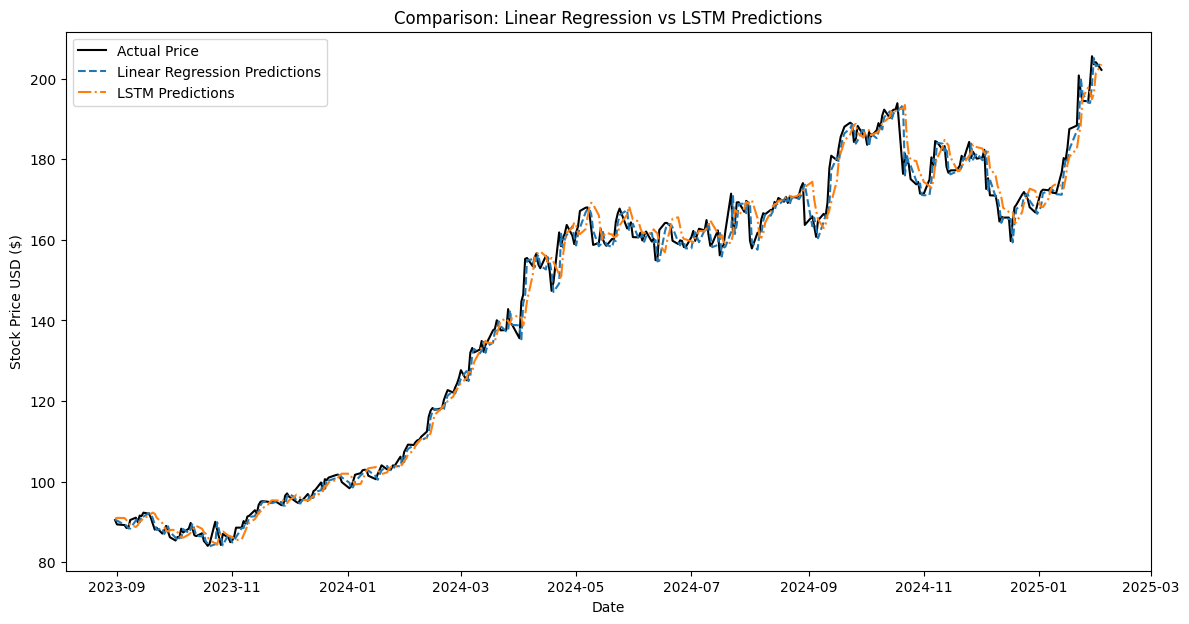

In [19]:
# Cell 8: Compare the Predictions from Both Models

# Ensure both predictions cover the same test period. We already have:
# - y_test_lr and y_pred_lr from Linear Regression
# - y_test_lstm (actual values) and lstm_predictions from LSTM

plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test_lr):], y_test_lr, label='Actual Price', color='black')
plt.plot(df.index[-len(y_test_lr):], y_pred_lr, label='Linear Regression Predictions', linestyle='--')
plt.plot(df.index[-len(y_test_lstm):], lstm_predictions, label='LSTM Predictions', linestyle='-.')
plt.title('Comparison: Linear Regression vs LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price USD ($)')
plt.legend()
plt.show()


In [20]:
import joblib

# Save Linear Regression model
joblib.dump(lr_model, "linear_regression.pkl")

# Save the MinMaxScaler
joblib.dump(scaler, "scaler.pkl")

# Save LSTM model
lstm_model.save("lstm_model.h5")